# Sneak peak case - Climate sentiment

## To-do

1. Improve sentiment analysis calculation.
2. Perform emotion analysis on snippets.
3. Find public surveys of people's oppinion about climate change and compare to snippet sentiments.
4. Check whether the TV-stations are pro-republican or pro-democrat and compare the differences.
5. Write down 5-10 concrete scenarios where this information would benefit the government. (e.g. hesitation of having children, economy, politics, ideology)
6. Find out what were the events that caused massive

## 1. Data import and cleaning

In [ ]:
pip install wordcloud

  Using cached wordcloud-1.8.1-cp37-cp37m-manylinux1_x86_64.whl (366 kB)
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# imports
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import re
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# importing all the csv files

# getting the names of all files
names = [f for f in listdir('data') if isfile(join('data', f))]  

dataframes = []

# reading them all in and adding them to a list
for file_name in names:
    file = open('data/'+ file_name, encoding="cp437")
    temp_df = pd.read_csv(file)
    dataframes.append(temp_df)

In [3]:
# checking if all the dataframes have the same number of columns, as I know for certain that one doesn't

df_to_delete = []

# getting the index of the messed up dataframes, deleting them
for i in range(len(dataframes)):
    if(dataframes[i].shape[1] != 7):
        df_to_delete.append(i)
for i in df_to_delete:
    del(dataframes[i])

In [4]:
# transforming the MatchDateTime column to month, day, year, and part of day

for df in dataframes:
    df["month"] = df.apply(lambda x: int(x["MatchDateTime"].split('/')[0]), axis=1)
    df["day"] = df.apply(lambda x: int(x["MatchDateTime"].split('/')[1]), axis=1)
    df["year"] = df.apply(lambda x: int(x["MatchDateTime"].split('/')[2].split(' ')[0]), axis=1)
    df["part of day"] = df.apply(lambda x: int(x["MatchDateTime"].split('/')[2].split(' ')[1].split(':')[0]), axis=1)
    df["part of day"] = df["part of day"].apply(lambda x: "morning" if(x >= 5 and x <= 12) else 
                                                                      ("afternoon" if (x >= 13 and x <= 17) else 
                                                                     ("evening" if(x >= 18 and x <= 21) else 
                                                                     "night")))
    # setting the index of the dataframe to be year, month, day so it is easier to plot and organize sentiment time wise, it is optional however
    df.set_index(['year', 'month', 'day'], inplace=True)
    # dropping the columns that aren't necessary
    df.drop(['IAPreviewThumb', 'MatchDateTime'], axis=1, inplace=True)
    # renaming the columns
    df.columns = ['url', 'station', 'show', 'showID', 'snippet',
       'part of day']

In [5]:
# combining all the dataframes into one df
# and we still have the cleaned dataframes organized in dataframes list

df = pd.concat(dataframes)

# sorting the final dataframe by year, month, day
df.sort_index()

url  station  \
year month day                                                               
2009 7     2    https://archive.org/details/FOXNEWS_20090702_2...  FOXNEWS   
           2    https://archive.org/details/MSNBC_20090702_190...    MSNBC   
           2    https://archive.org/details/MSNBC_20090702_180...    MSNBC   
           3    https://archive.org/details/CNN_20090703_15000...      CNN   
           3    https://archive.org/details/CNN_20090703_20000...      CNN   
...                                                           ...      ...   
2020 1     21   https://archive.org/details/FOXNEWSW_20200121_...  FOXNEWS   
           21   https://archive.org/details/FOXNEWSW_20200121_...  FOXNEWS   
           21   https://archive.org/details/FOXNEWSW_20200121_...  FOXNEWS   
           21   https://archive.org/details/FOXNEWSW_20200121_...  FOXNEWS   
           21   https://archive.org/details/FOXNEWSW_20200121_...  FOXNEWS   

                                                show  \
year month day                                         
2009 7     2          Special Report With Bret Baier   
           2                         MSNBC News Live   
           2                         MSNBC News Live   
           3                            CNN Newsroom   
           3    The Situation Room With Wolf Blitzer   
...                                              ...   
2020 1     21                        FOX and Friends   
           21                     FOX  Friends First   
           21   Fox News at Night With Shannon Bream   
           21   Fox News at Night With Shannon Bream   
           21   Fox News at Night With Shannon Bream   

                                                           showID  \
year month day                                                      
2009 7     2    FOXNEWS_20090702_221612_Special_Report_With_Br...   
           2                MSNBC_20090702_190000_MSNBC_News_Live   
           2                MSNBC_20090702_180000_MSNBC_News_Live   
           3                     CNN_20090703_150000_CNN_Newsroom   
           3    CNN_20090703_200000_The_Situation_Room_With_Wo...   
...                                                           ...   
2020 1     21            FOXNEWSW_20200121_110000_FOX_and_Friends   
           21         FOXNEWSW_20200121_100000_FOX__Friends_First   
           21   FOXNEWSW_20200121_040000_Fox_News_at_Night_Wit...   
           21   FOXNEWSW_20200121_080000_Fox_News_at_Night_Wit...   
           21   FOXNEWSW_20200121_080000_Fox_News_at_Night_Wit...   

                                                          snippet part of day  
year month day                                                                 
2009 7     2    they spent in the fat years money on such fash...       night  
           2    ma a lf headway with th climate change bill an...     evening  
           2    represesentitis passed ann traordinary piece o...     evening  
           3    disease. gridlock. global warming. it can help...   afternoon  
           3    support for education initiatives and filled p...     evening  
...                                                           ...         ...  
2020 1     21   ainsley: i see ivanka in the background. steve...     morning  
           21   president has a lot of good news economically,...     morning  
           21   climate change. the serious point is their app...       night  
           21   each other engage in debate. when trump first ...     morning  
           21   inequality and diversity and climate change bu...     morning  

[94858 rows x 6 columns]

## 2. Data visualisation

In [6]:
df_copy = df.reset_index()

# Create a df with unique combinations of year and month
df_count = df_copy[['year','month']].drop_duplicates()
df_count = df_count.sort_values(['year', 'month'])
stations = df['station'].drop_duplicates()

# Assign number of snippets for each TV station and month
for s in stations:
    df_count[s] = 0
    for i, row in df_count.iterrows():
        df_count.at[i, s] = len(df_copy[(df_copy['year'] == row['year']) & (df_copy['month'] == row['month']) & (df_copy['station'] == s)])

# Combine to date for plots
df_count['month'] = df_count['month'].astype(str)
df_count['month'] = df_count['month'].apply(lambda x: x.zfill(2))

df_count['date'] = (df_count['year']).astype(str) +'-'+ (df_count['month']).astype(str)

df_count


,year,month,CNN,FOXNEWS,MSNBC,BBCNEWS,date
4889,2009,07,170,422,90,0,2009-07
19943,2009,08,65,143,133,0,2009-08
8074,2009,09,19,264,144,0,2009-09
24601,2009,10,0,418,203,0,2009-10
3639,2009,11,134,483,123,0,2009-11
...,...,...,...,...,...,...,...
37253,2019,09,701,810,937,1322,2019-09
7619,2019,10,216,230,217,664,2019-10
19423,2019,11,328,272,398,1362,2019-11
5930,2019,12,374,219,317,2103,2019-12


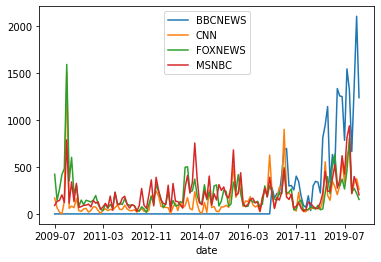

In [7]:
ax = plt.gca()

df_count.plot(x='date', y="BBCNEWS",ax=ax) #, title='Interactions regarding climate topics across the time')
df_count.plot(x='date', y="CNN",ax=ax)
df_count.plot(x='date', y="FOXNEWS",ax=ax)
df_count.plot(x='date', y="MSNBC",ax=ax)


plt.rcParams["figure.figsize"] = (16,8)
plt.show()

In [8]:
# Create a df with unique parts of the day
df_day_parts = df_copy[['part of day']].drop_duplicates()
df_day_parts = df_day_parts.sort_values(['part of day'])
stations = df['station'].drop_duplicates()

# Assign number of snippets for each TV station and part of the day
for s in stations:
    df_day_parts[s] = 0
    for i, row in df_day_parts.iterrows():
        df_day_parts.at[i, s] = len(df_copy[(df_copy['part of day'] == row['part of day']) & (df_copy['station'] == s)])

#works only on pandas >1.1.0
ordering_dict = {'morning': 0, 'afternoon': 1, 'evening': 2, 'night': 3}
df_day_parts = df_day_parts.sort_values(by=['part of day'], key = lambda x: x.map(ordering_dict))

df_day_parts

,part of day,CNN,FOXNEWS,MSNBC,BBCNEWS
0,morning,6583,9037,6898,6828
2,afternoon,4564,3818,5863,4318
1,evening,3250,4121,5367,3975
4,night,4907,8889,8301,8139


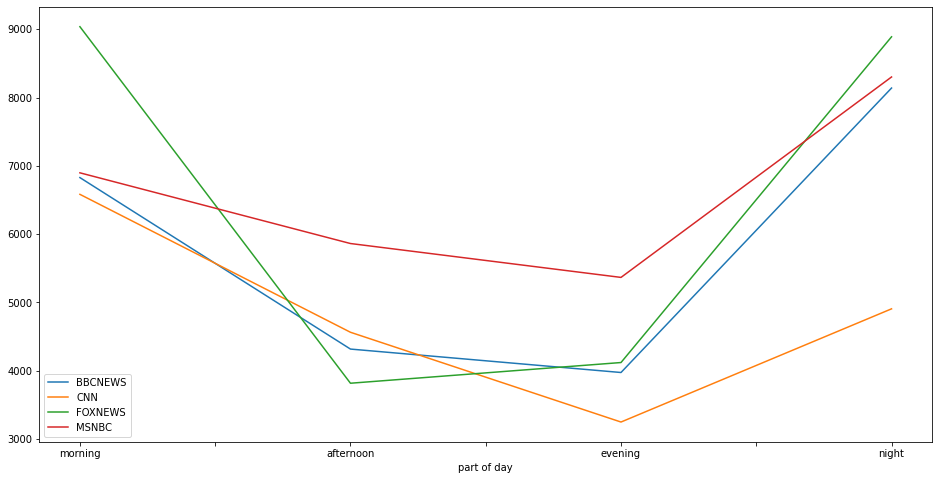

In [9]:
ax = plt.gca()

df_day_parts.plot(x='part of day', y="BBCNEWS",ax=ax) #, title='Absolute distribution of interactions during the day')
df_day_parts.plot(x='part of day', y="CNN",ax=ax)
df_day_parts.plot(x='part of day', y="FOXNEWS",ax=ax)
df_day_parts.plot(x='part of day', y="MSNBC",ax=ax)

plt.show()

In [11]:
# Calculate relative number of interactions per part of the day
df_day_parts_relative = df_day_parts
list_of_sums = []
for s in stations:
    station_sum = df_day_parts_relative[s].sum()
    list_of_sums.append(station_sum)
    df_day_parts_relative[s] = df_day_parts_relative[s]/station_sum

print(list_of_sums)
df_day_parts_relative


[19304, 25865, 26429, 23260]


,part of day,CNN,FOXNEWS,MSNBC,BBCNEWS
0,morning,0.341017,0.349391,0.261001,0.293551
2,afternoon,0.236428,0.147613,0.221840,0.185641
1,evening,0.168359,0.159327,0.203072,0.170894
4,night,0.254196,0.343669,0.314087,0.349914


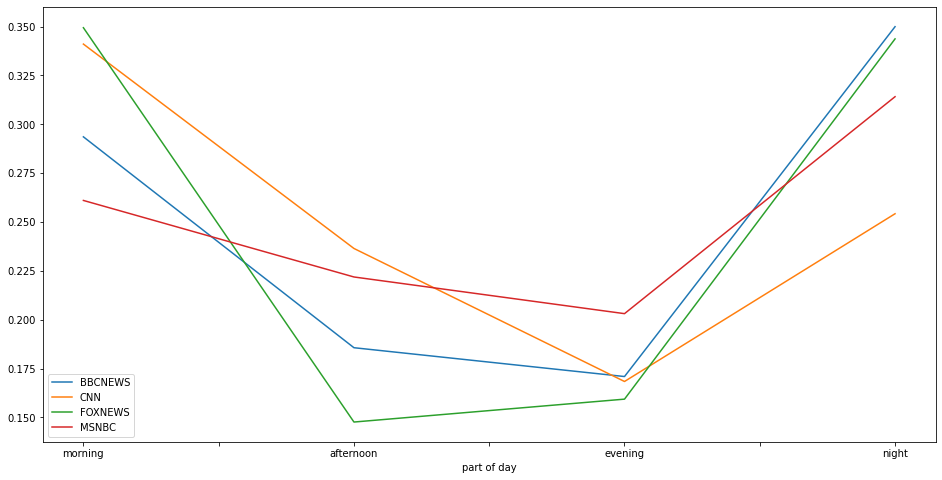

In [12]:
ax = plt.gca()

df_day_parts_relative.plot(x='part of day', y="BBCNEWS",ax=ax) #, title='Relative distribution of interactions during the day')
df_day_parts_relative.plot(x='part of day', y="CNN",ax=ax)
df_day_parts_relative.plot(x='part of day', y="FOXNEWS",ax=ax)
df_day_parts_relative.plot(x='part of day', y="MSNBC",ax=ax)

plt.show()

## 3. Sentiment Analysis

In [13]:

wordnet_lemmatizer = WordNetLemmatizer()
stopwords = stopwords.words('english')

In [14]:
# remove all the punctuations
df['snippet'] = df['snippet'].apply(lambda x: re.sub(r'[.,"\'%\[\]\-?:!;]', '', x))

# remove stopwords
df['snippet'] = df['snippet'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in (stopwords)]))

# lemmatization
df['snippet'] = df['snippet'].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word) for word in x.split(' ')]))

# calculate the polarity
df['polarity'] = df['snippet'].apply(lambda x: TextBlob(x).sentiment.polarity)

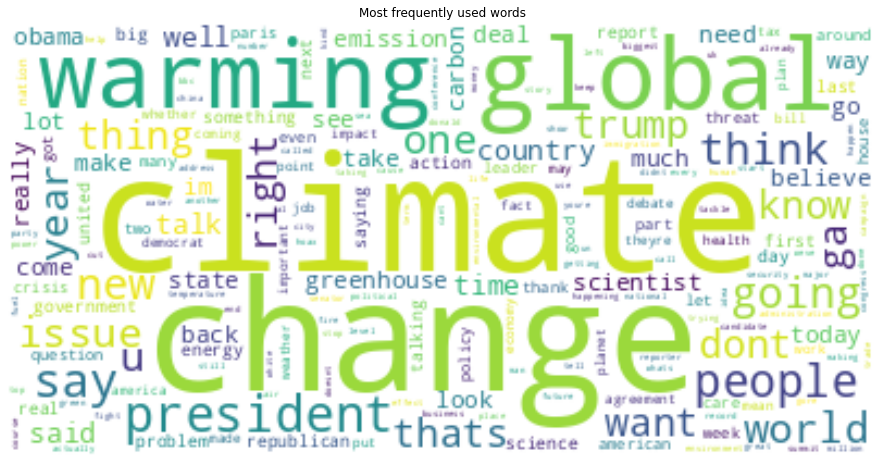

In [15]:
# calculate wordCloud for the snippets
snippets_combined = ' '.join([item for item in df['snippet']])

word_cloud = WordCloud(collocations = False, background_color = 'white').generate(snippets_combined)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.title('Most frequently used words')
plt.axis("off")
plt.show()

In [16]:
# create a datetime index so I can group thigs by month

df.reset_index(inplace=True)
df['date']=pd.to_datetime(df[['year','month','day']])
df.set_index('date', inplace=True)
# df.drop(['year', 'month', 'day'], axis=1,  inplace=True)

Text(0.5, 0, 'Year')

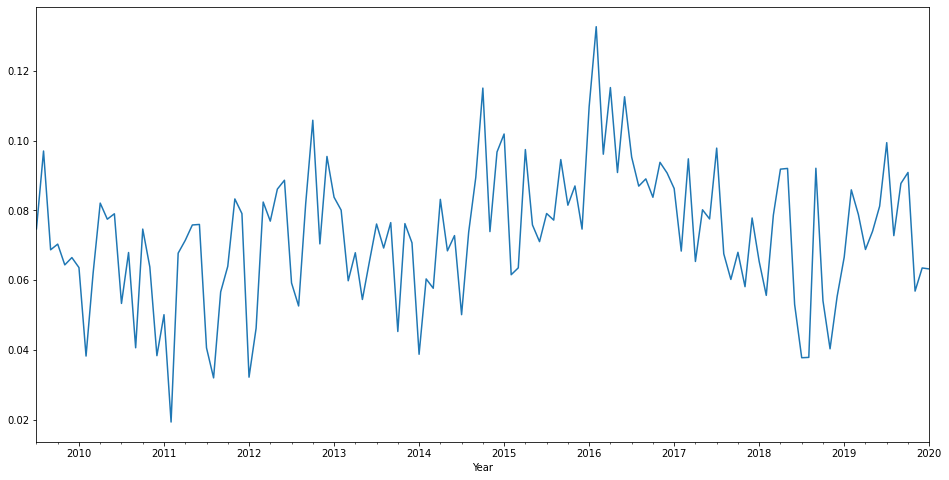

In [17]:
# sentiment trends
df.groupby(pd.Grouper(freq='M'))['polarity'].mean().plot()
plt.xlabel('Year')

<AxesSubplot:xlabel='month'>

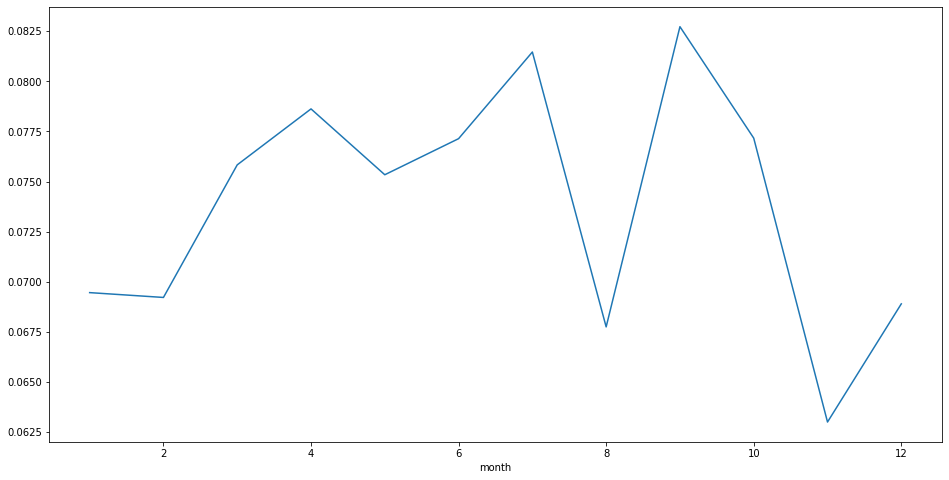

In [18]:
# sentiment trends
df.groupby('month').mean()['polarity'].plot()

Text(0.5, 1.0, 'Snippets over time')

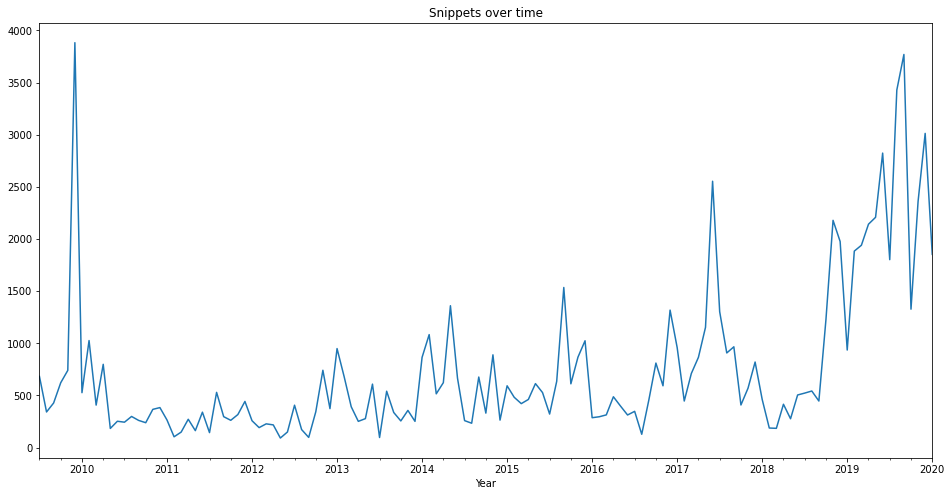

In [19]:
# snippets over time
df.groupby(pd.Grouper(freq='M')).count()['snippet'].plot()
plt.xlabel('Year')
plt.title('Snippets over time')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5dad1efb-9205-4e33-b917-077f54d8f326' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>